# Finger Printing Inequality for Multiple Access Channels

This notebook explores the performance against a finger printing task where the receiver must output $0$ when inputs $x=y$ and $1$ otherwise.
The notebook demonstrates that quantum communication provides no advantage in this task, however, entanglement shared between the senders yields an advantage when classical communication is used.

In [41]:
from context import QNetOptimizer as QNopt
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

In [42]:
arb_prep_nodes = [
    QNopt.PrepareNode(3, [0], qml.templates.subroutines.ArbitraryUnitary, 3),
    QNopt.PrepareNode(3, [1], qml.templates.subroutines.ArbitraryUnitary, 3),
]
arb_meas_nodes = [
    QNopt.MeasureNode(1, 4, [0,1], qml.templates.subroutines.ArbitraryUnitary, 15)
]

arb_ansatz = QNopt.NetworkAnsatz(arb_prep_nodes, arb_meas_nodes)

local_meas_nodes = [
    QNopt.MeasureNode(1, 2, [0], qml.templates.subroutines.ArbitraryUnitary, 3),
    QNopt.MeasureNode(1, 2, [1], qml.templates.subroutines.ArbitraryUnitary, 3)
]

local_ansatz = QNopt.NetworkAnsatz(arb_prep_nodes, local_meas_nodes)

ea_prep_nodes = [
    QNopt.PrepareNode(1, [0,1], qml.templates.subroutines.ArbitraryUnitary, 15)
]

ea_meas_nodes = [
    QNopt.MeasureNode(3, 2, [0], qml.templates.subroutines.ArbitraryUnitary, 3),
    QNopt.MeasureNode(3, 2, [1], qml.templates.subroutines.ArbitraryUnitary, 3)
]

ea_ansatz = QNopt.NetworkAnsatz(ea_prep_nodes, ea_meas_nodes)

In [43]:
def priors_scan_range(num_steps):
    eps = 1e-10
    x1_range = np.arange(0,1+eps,1/num_steps)

    priors = []
    for x1 in x1_range:
        x2_range = np.arange(0,1-x1+eps,1/num_steps)
        for x2 in x2_range:
            priors.append(np.array([x1,x2,1-x1-x2]))
        
    return priors

def plot_rate_region(rate_tuple):
    r1, r2, r_sum = rate_tuple
    
    r1_vals = [0,0,r_sum-r2,r1,r1,0]
    r2_vals = [0,r2,r2,r_sum-r1,0,0]
    
    plt.plot(r1_vals, r2_vals,"b-",label="Quantum")
    plt.plot([0,0,1,0],[0,1,0,0],"r--",label="Classical")
    plt.legend()
    plt.title("Multiple Access Channel Rate Regions")
    plt.xlabel("Rate 1")
    plt.ylabel("Rate 2")
    plt.show()

The finger printing inequality rewards correct answers with a score of 1 and for wrong answers gives 0.

In [13]:
finger_printing_ineq = np.array([
    [1,0,0,0,1,0,0,0,1],
    [0,1,1,1,0,1,1,1,0]
])

## Classical Ansatz

In [15]:
%%time

fp_local_settings = local_ansatz.rand_scenario_settings()
fp_local_fingerprint_cost = QNopt.linear_probs_cost(local_ansatz, finger_printing_ineq)

fp_local_opt_dict = QNopt.gradient_descent(
    fp_local_fingerprint_cost,
    fp_local_settings,
    step_size=0.1,
    num_steps=150,
    sample_width=25
)

print(fp_local_opt_dict["opt_score"])

iteration :  0 , score :  4.541326149652934
iteration :  25 , score :  6.38140970386077
iteration :  50 , score :  6.796491465790103
iteration :  75 , score :  6.943932414386689
iteration :  100 , score :  6.977295586159736
iteration :  125 , score :  6.988304316222181
6.993293830189421
CPU times: user 13.4 s, sys: 61.8 ms, total: 13.5 s
Wall time: 13.5 s


6.993293830189411
id :  351
rate tuple :  (0.967906801806536, 0.9678463301978146, 0.9958124952998704)
priors tuple :  (tensor([0.6, 0.2, 0.2], requires_grad=True), tensor([0.6, 0. , 0.4], requires_grad=True))


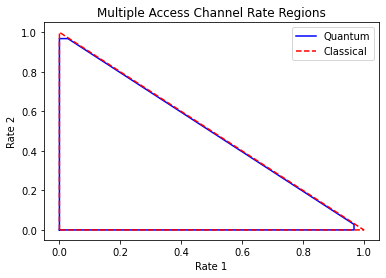

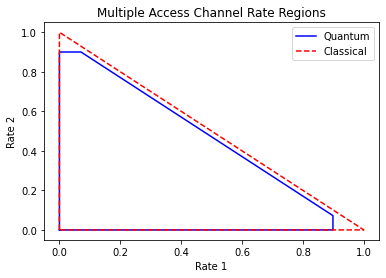

In [40]:
local_behavior = QNopt.network_behavior_fn(local_ansatz)
local_opt_behavior4 = local_behavior(fp_local_opt_dict["opt_settings"])

cg_map = np.array([[1,0,0,1],[0,1,1,0]])

local_opt_behavior = cg_map @ local_opt_behavior4


print(np.sum(np.sum(local_opt_behavior * finger_printing_ineq)))

local_rates = []
priors = []
for priors_x in priors_scan_range(5):
    for priors_y in priors_scan_range(5):
        priors.append((priors_x, priors_y))
        local_rates.append(QNopt.bisender_mac_mutual_info(local_opt_behavior, priors_x, priors_y))
        
local_rate_sums = [sum(rate_set) for rate_set in local_rates]
max_local_rate_sum = max(local_rate_sums)
max_local_rate_id = local_rate_sums.index(max_local_rate_sum)
max_local_rate_tuple = local_rates[max_local_rate_id]

print("id : ", max_local_rate_id)
print("rate tuple : ", max_local_rate_tuple)
print("priors tuple : ", priors[max_local_rate_id])
plot_rate_region(max_local_rate_tuple)

uniform_rates = QNopt.bisender_mac_mutual_info(local_opt_behavior, np.ones(3)/3, np.ones(3)/3)
plot_rate_region(uniform_rates)

## Quantum Communication Ansatz

In [16]:
%%time

fp_arb_settings = arb_ansatz.rand_scenario_settings()
fp_arb_fingerprint_cost = QNopt.linear_probs_cost(arb_ansatz, finger_printing_ineq)

fp_arb_opt_dict = QNopt.gradient_descent(
    fp_arb_fingerprint_cost,
    fp_arb_settings,
    step_size=0.1,
    num_steps=200,
    sample_width=25
)

print(fp_arb_opt_dict["opt_score"])

iteration :  0 , score :  4.2472477378531055
iteration :  25 , score :  6.621041688726793
iteration :  50 , score :  6.908575160596325
iteration :  75 , score :  6.964912707621812
iteration :  100 , score :  6.982583258021933
iteration :  125 , score :  6.990207206899572
iteration :  150 , score :  6.994022559849804
iteration :  175 , score :  6.996105998055843
6.997322432105971
CPU times: user 31.4 s, sys: 116 ms, total: 31.5 s
Wall time: 31.5 s


6.99732243210595
[[9.95815986e-01 5.31432937e-04 9.95022090e-01 4.31852936e-06
  9.98273261e-01 2.30178368e-04 9.96890521e-01 1.84173397e-04
  9.96095899e-01]
 [4.18401382e-03 9.99468567e-01 4.97791006e-03 9.99995681e-01
  1.72673930e-03 9.99769822e-01 3.10947931e-03 9.99815827e-01
  3.90410091e-03]]
id :  380
rate tuple :  (0.9871585004393353, 0.9871586798340668, 0.987158940770819)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))


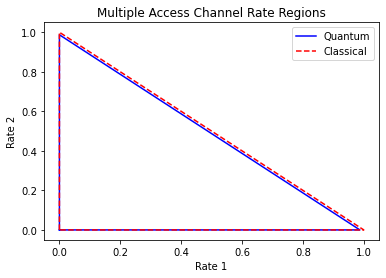

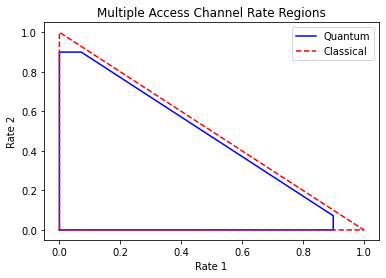

In [37]:
arb_behavior = QNopt.network_behavior_fn(arb_ansatz)
arb_opt_behavior4 = arb_behavior(fp_arb_opt_dict["opt_settings"])

cg_map = np.array([[1,0,0,1],[0,1,1,0]])

arb_opt_behavior = cg_map @ arb_opt_behavior4


print(np.sum(np.sum(arb_opt_behavior * finger_printing_ineq)))
print(arb_opt_behavior)

arb_rates = []
priors = []
for priors_x in priors_scan_range(10):
    for priors_y in priors_scan_range(10):
        priors.append((priors_x, priors_y))
        arb_rates.append(QNopt.bisender_mac_mutual_info(arb_opt_behavior, priors_x, priors_y))
        
arb_rate_sums = [sum(rate_set) for rate_set in arb_rates]
max_arb_rate_sum = max(arb_rate_sums)
max_arb_rate_id = arb_rate_sums.index(max_arb_rate_sum)
max_arb_rate_tuple = arb_rates[max_arb_rate_id]

print("id : ", max_arb_rate_id)
print("rate tuple : ", max_arb_rate_tuple)
print("priors tuple : ", priors[max_arb_rate_id])
plot_rate_region(max_arb_rate_tuple)

uniform_rates = QNopt.bisender_mac_mutual_info(arb_opt_behavior, np.ones(3)/3, np.ones(3)/3)
plot_rate_region(uniform_rates)

## Entanglement Assisted Classical Ansatz

In [17]:
%%time

fp_ea_settings = ea_ansatz.rand_scenario_settings()
fp_ea_fingerprint_cost = QNopt.linear_probs_cost(ea_ansatz, finger_printing_ineq)

fp_ea_opt_dict = QNopt.gradient_descent(
    fp_ea_fingerprint_cost,
    fp_ea_settings,
    step_size=0.1,
    num_steps=200,
    sample_width=25
)

print(fp_ea_opt_dict["opt_score"])

iteration :  0 , score :  5.487444246278516
iteration :  25 , score :  6.936809665185764
iteration :  50 , score :  7.271183465729079
iteration :  75 , score :  7.409274007902367
iteration :  100 , score :  7.468408697658363
iteration :  125 , score :  7.490072757356253
iteration :  150 , score :  7.4970542664451
iteration :  175 , score :  7.499150345135083
7.4997583136186226
CPU times: user 33.3 s, sys: 180 ms, total: 33.4 s
Wall time: 33.5 s


7.499758313618609
[[9.99938420e-01 2.42744070e-01 2.49507126e-01 2.43262546e-01
  9.99917587e-01 2.56820249e-01 2.50183111e-01 2.57518968e-01
  9.99938377e-01]
 [6.15803269e-05 7.57255930e-01 7.50492874e-01 7.56737454e-01
  8.24128412e-05 7.43179751e-01 7.49816889e-01 7.42481032e-01
  6.16233242e-05]]
id :  3350
rate tuple :  (0.5564540330718803, 0.5564540413519228, 0.5564540888131537)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))


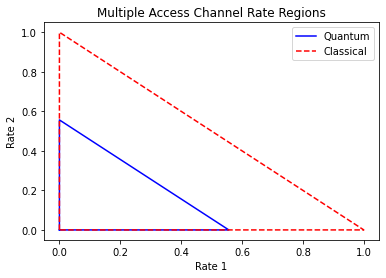

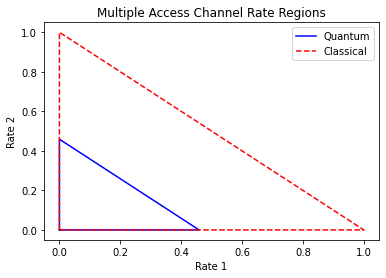

In [36]:
ea_behavior = QNopt.network_behavior_fn(ea_ansatz)
ea_opt_behavior4 = ea_behavior(fp_ea_opt_dict["opt_settings"])

cg_map = np.array([[1,0,0,1],[0,1,1,0]])

ea_opt_behavior = cg_map @ ea_opt_behavior4


print(np.sum(np.sum(ea_opt_behavior * finger_printing_ineq)))
print(ea_opt_behavior)

ea_rates = []
priors = []
for priors_x in priors_scan_range(10):
    for priors_y in priors_scan_range(10):
        priors.append((priors_x, priors_y))
        ea_rates.append(QNopt.bisender_mac_mutual_info(ea_opt_behavior, priors_x, priors_y))

        
ea_rate_sums = [sum(rate_set) for rate_set in ea_rates]
max_ea_rate_sum = max(ea_rate_sums)
max_ea_rate_id = ea_rate_sums.index(max_ea_rate_sum)
max_ea_rate_tuple = ea_rates[max_ea_rate_id]

print("id : ", max_ea_rate_id)
print("rate tuple : ", max_ea_rate_tuple)
print("priors tuple : ", priors[max_ea_rate_id])
plot_rate_region(max_ea_rate_tuple)

uniform_rates = QNopt.bisender_mac_mutual_info(ea_opt_behavior, np.ones(3)/3, np.ones(3)/3)

plot_rate_region(uniform_rates)

## Rate Region for the "Perfect" Finger Printing Strategy

9
id :  335
rate tuple :  (1.0, 1.0, 1.0)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))


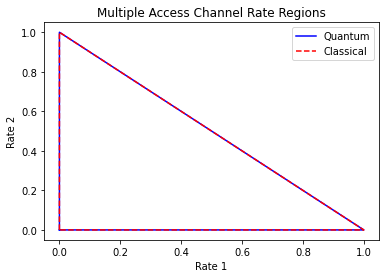

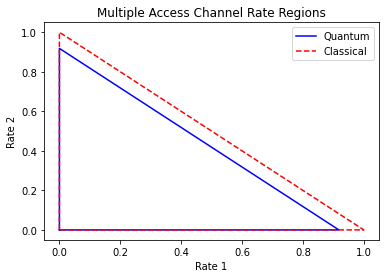

In [44]:
perfect_behavior = np.array([
    [1,0,0,0,1,0,0,0,1],[0,1,1,1,0,1,1,1,0]
])


print(np.sum(np.sum(perfect_behavior * finger_printing_ineq)))

perf_rates = []
priors = []
for priors_x in priors_scan_range(10):
    for priors_y in priors_scan_range(10):
        priors.append((priors_x, priors_y))
        perf_rates.append(QNopt.bisender_mac_mutual_info(perfect_behavior, priors_x, priors_y))

        
perf_rate_sums = [sum(rate_set) for rate_set in perf_rates]
max_perf_rate_sum = max(perf_rate_sums)
max_perf_rate_id = perf_rate_sums.index(max_perf_rate_sum)
max_perf_rate_tuple = perf_rates[max_ea_rate_id]

print("id : ", max_perf_rate_id)
print("rate tuple : ", max_perf_rate_tuple)
print("priors tuple : ", priors[max_perf_rate_id])
plot_rate_region(max_perf_rate_tuple)

uniform_rates = QNopt.bisender_mac_mutual_info(perfect_behavior, np.ones(3)/3, np.ones(3)/3)

plot_rate_region(uniform_rates)